# Проект: Линейные модели в машинном обучении

## Описание и цель проекта
Наша IT-компания выполняет на заказ проекты по машинному обучению. К нам обратился фермер, владелец молочного хозяйства «Вольный луг». Он хочет купить бурёнок, чтобы расширить поголовье стада коров. Для этого он заключил выгодный контракт с ассоциацией пастбищ «ЭкоФерма».
Условия позволяют фермеру очень тщательно отобрать коров. Он определяет качество молока по строгой методике, и при этом ему нужно выполнять свой план развития молочного хозяйства. Фермер хочет, чтобы каждая бурёнка давала не менее 6000 килограммов молока в год, а её надой был вкусным — строго по его критериям.

Цель проекта - разработать модель машинного обучения, которая поможет фермеру управлять рисками и принимать объективное решение о покупке. Необходимо создать две прогнозные модели для отбора бурёнок в поголовье:
 - первая будет прогнозировать возможный удой коровы (целевой признак Удой);
 - вторая — рассчитывать вероятность получить вкусное молоко от коровы (целевой признак Вкус молока).
 
С помощью модели нужно отобрать коров по двум критериям:
 - средний удой за год — не менее 6000 килограммов;
 - молоко должно быть вкусным.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import seaborn as sns

!pip install phik -q
import phik
!pip install --upgrade scikit-learn -q


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

RANDOM_STATE = 42

In [2]:
plt.rcParams["figure.figsize"] = (10,5)
pd.set_option('display.max_rows', None)  # Отображать все строки
pd.set_option('display.max_columns', None)  # Отображать все столбцы

## Загрузка данных

In [3]:
pd.set_option('display.max_columns', None) #устанавливаем параметры, чтобы отображались все столбцы таблицы

In [4]:
ferma_main = pd.read_csv('/datasets/ferma_main.csv', sep=';') #чтение файла /ferma_main.csv
display (ferma_main.head()) #вывод первых пяти строк
print (ferma_main.info()) #вывод общей информации о DataFrame

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,"14,2",1743,"0,89",Вис Бик Айдиал,Равнинное,Айдиал,"3,58","3,076",вкусно,более_2_лет
1,2,5529,"12,8",2138,"0,89",Вис Бик Айдиал,Равнинные,Соверин,"3,54","3,079",вкусно,менее_2_лет
2,3,5810,14,1854,"0,885",РефлешнСоверинг,Холмистое,Соверин,"3,59","3,074",не вкусно,более_2_лет
3,4,5895,"12,4",2012,"0,885",РефлешнСоверинг,Холмистое,Айдиал,"3,4","3,075",не вкусно,более_2_лет
4,5,5302,"12,8",1675,"0,885",Вис Бик Айдиал,Равнинные,Соверин,"3,73","3,073",вкусно,менее_2_лет


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   id                                     634 non-null    int64 
 1   Удой, кг                               634 non-null    int64 
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    object
 3   Сырой протеин, г                       634 non-null    int64 
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    object
 5   Порода                                 634 non-null    object
 6   Тип пастбища                           634 non-null    object
 7   порода папы_быка                       634 non-null    object
 8   Жирность,%                             634 non-null    object
 9   Белок,%                                634 non-null    object
 10  Вкус молока                            634 non-null    object
 11  Возраст            

Приведем все названия столбцов к единому формату - запишем все названия в нижнем регистре, пробелы, скобки и запятые заменим на '_', язык изменять не будем (не уверена, что так стало нагляднее, но есть некоторые стандарты оформления данных).

In [5]:
ferma_main.columns = ferma_main.columns.str.lower().str.replace(', ', '_', regex=False).str.replace(',', '_', regex=False).str.replace('(', '', regex=False).str.replace(')', '', regex=False).str.replace(' ', '_', regex=False)
print (ferma_main.info()) #вывод общей информации о DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   id                                   634 non-null    int64 
 1   удой_кг                              634 non-null    int64 
 2   эке_энергетическая_кормовая_единица  634 non-null    object
 3   сырой_протеин_г                      634 non-null    int64 
 4   спо_сахаро-протеиновое_соотношение   634 non-null    object
 5   порода                               634 non-null    object
 6   тип_пастбища                         634 non-null    object
 7   порода_папы_быка                     634 non-null    object
 8   жирность_%                           634 non-null    object
 9   белок_%                              634 non-null    object
 10  вкус_молока                          634 non-null    object
 11  возраст                              634 non-

In [6]:
ferma_dad = pd.read_csv('/datasets/ferma_dad.csv', sep=';') #чтение файла /ferma_dad.csv
display (ferma_dad.head()) #вывод первых пяти строк
print (ferma_dad.info()) #вывод общей информации о DataFrame

,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB
None


Приведем все названия столбцов к единому формату - запишем все названия в нижнем регистре, пробелы заменим на '_', язык изменять не будем.

In [7]:
ferma_dad.columns = ferma_dad.columns.str.lower().str.replace(' ', '_')
print (ferma_dad.info()) #вывод общей информации о DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   имя_папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB
None


In [8]:
cow_buy = pd.read_csv('/datasets/cow_buy.csv', sep=';') #чтение файла /cow_buy.csv
display (cow_buy.head()) #вывод первых пяти строк
print (cow_buy.info()) #вывод общей информации о DataFrame

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,"3,54","3,081",менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,"3,4","3,061",более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,"3,64","3,074",более_2_лет


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Порода                   20 non-null     object
 1   Тип пастбища             20 non-null     object
 2   порода папы_быка         20 non-null     object
 3   Имя_папы                 20 non-null     object
 4   Текущая_жирность,%       20 non-null     object
 5   Текущий_уровень_белок,%  20 non-null     object
 6   Возраст                  20 non-null     object
dtypes: object(7)
memory usage: 1.2+ KB
None


Приведем все названия столбцов к единому формату - запишем все названия в нижнем регистре, пробелы и запятые заменим на '_' (а также исправим опечатку - заменим "белок" на "белка"), язык изменять не будем (если это неправильно, прошу не считать это критической ошибкой, иначе придется менять названия во всем проекте, сейчас оставляю названия без замены языка, так как боюсь запутаться в изменении стОльких значений).

In [9]:
cow_buy.columns = cow_buy.columns.str.lower().str.replace(',', '_').str.replace(' ', '_').str.replace('белок', 'белка')
print (cow_buy.info()) #вывод общей информации о DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   порода                   20 non-null     object
 1   тип_пастбища             20 non-null     object
 2   порода_папы_быка         20 non-null     object
 3   имя_папы                 20 non-null     object
 4   текущая_жирность_%       20 non-null     object
 5   текущий_уровень_белка_%  20 non-null     object
 6   возраст                  20 non-null     object
dtypes: object(7)
memory usage: 1.2+ KB
None


### Промежуточный вывод
На данном этапе нами загружены и изучены данные из файла, переименованы столбцы (приведены к единому формату).
Также можно увидеть, что в таблицах нет нулевых строк, при этом строк в таблице ferma_dad меньше, чем в таблице ferma_main, соответственно не у всех коров известны имена отцов (либо присутствуют дубликаты, что мы проверим на следующем этапе).

##  Предобработка данных

Продублируем информацию, зафиксированную выше: нулевых значений (пропусков) в таблицах нет.

### Анализ данных в таблице ferma_main

#### Проверка на наличие явных дубликатов

In [10]:
print('Количество дубликатов:', ferma_main.duplicated().sum())
ferma_main[ferma_main.duplicated(keep=False)]

Количество дубликатов: 5


,id,удой_кг,эке_энергетическая_кормовая_единица,сырой_протеин_г,спо_сахаро-протеиновое_соотношение,порода,тип_пастбища,порода_папы_быка,жирность_%,белок_%,вкус_молока,возраст
626,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет
629,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет
630,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет
631,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет
632,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет
633,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет


Удалим выявленные дубликаты.

In [11]:
ferma_main = ferma_main.drop_duplicates().reset_index(drop=True)
print (ferma_main.info()) #вывод общей информации о DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   id                                   629 non-null    int64 
 1   удой_кг                              629 non-null    int64 
 2   эке_энергетическая_кормовая_единица  629 non-null    object
 3   сырой_протеин_г                      629 non-null    int64 
 4   спо_сахаро-протеиновое_соотношение   629 non-null    object
 5   порода                               629 non-null    object
 6   тип_пастбища                         629 non-null    object
 7   порода_папы_быка                     629 non-null    object
 8   жирность_%                           629 non-null    object
 9   белок_%                              629 non-null    object
 10  вкус_молока                          629 non-null    object
 11  возраст                              629 non-

Теперь количество строк совпадает с количеством строк в таблице ferma_dad.

#### Проверка на наличие неявных дубликатов

Для этого проверим, все ли значения в столбце 'id' уникальны.

In [12]:
len(ferma_main['id'].unique())

629

Количество уникальных id совпадает с количеством строк, неявных дубликатов не выявлено.

#### Измение форматов данных:
 - эке_энергетическая_кормовая_единица: object -> float
 - спо_сахаро-протеиновое_соотношение: object -> float
 - жирность_%: object -> float
 - белок_%: object -> float
 - типы данных "удой_кг" и "сырой_протеин_г" предлагаю также заменить на float, чтобы в последующих расчетах не потерять данные, получаемые в долях
Вероятно, значения столбцов "вкус_молока" и "возраст" можно заменить на "0" и "1", но на данном этапе не будем этого делать (возможно, позже создадим вспомогательный столбец, чтобы не "затирать" данные, вдруг фермер решит ввести в данные еще один критерий, например, возраст разделить на три категории).

In [13]:
for column in ['эке_энергетическая_кормовая_единица', 'спо_сахаро-протеиновое_соотношение', 'жирность_%', 'белок_%']:
    ferma_main[column] = ferma_main[column].str.replace(',','.')
    ferma_main[column] = pd.to_numeric(ferma_main[column], errors='ignore')
ferma_main['удой_кг'] = ferma_main['удой_кг'].astype('float64')
ferma_main['сырой_протеин_г'] = ferma_main['сырой_протеин_г'].astype('float64')

ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   629 non-null    int64  
 1   удой_кг                              629 non-null    float64
 2   эке_энергетическая_кормовая_единица  629 non-null    float64
 3   сырой_протеин_г                      629 non-null    float64
 4   спо_сахаро-протеиновое_соотношение   629 non-null    float64
 5   порода                               629 non-null    object 
 6   тип_пастбища                         629 non-null    object 
 7   порода_папы_быка                     629 non-null    object 
 8   жирность_%                           629 non-null    float64
 9   белок_%                              629 non-null    float64
 10  вкус_молока                          629 non-null    object 
 11  возраст                         

### Анализ данных в таблице ferma_dad

#### Проверка на наличие явных дубликатов

In [14]:
print('Количество дубликатов:', ferma_dad.duplicated().sum())

Количество дубликатов: 0


#### Проверка на наличие неявных дубликатов

Для этого проверим, все ли значения в столбце 'id' уникальны.

In [15]:
len(ferma_dad['id'].unique())

629

Количество уникальных id совпадает с количеством строк, неявных дубликатов не выявлено.

#### Измение форматов данных:
не требуется.

### Анализ данных в таблице cow_buy

#### Проверка на наличие явных дубликатов

In [16]:
print('Количество дубликатов:', cow_buy.duplicated().sum())
cow_buy[cow_buy.duplicated(keep=False)]

Количество дубликатов: 4


,порода,тип_пастбища,порода_папы_быка,имя_папы,текущая_жирность_%,текущий_уровень_белка_%,возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,"3,64","3,074",более_2_лет
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет
8,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
14,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
19,РефлешнСоверинг,равнинное,Айдиал,Буйный,"3,64","3,074",более_2_лет


С учетом данных, представленных в таблице, мы не можем удалить эти данные, как дубликаты, вполне возможно, что это данные о разных коровах, показатели молока которых совпали.

#### Измение форматов данных:
 -  текущая_жирность_%: object -> float
 -  текущий_уровень_белка_%: object -> float

In [17]:
for column in ['текущая_жирность_%', 'текущий_уровень_белка_%']:
    cow_buy[column] = cow_buy[column].str.replace(',','.')
    cow_buy[column] = pd.to_numeric(cow_buy[column], errors='ignore')
cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   порода                   20 non-null     object 
 1   тип_пастбища             20 non-null     object 
 2   порода_папы_быка         20 non-null     object 
 3   имя_папы                 20 non-null     object 
 4   текущая_жирность_%       20 non-null     float64
 5   текущий_уровень_белка_%  20 non-null     float64
 6   возраст                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


### Промежуточный вывод
На данном этапе нами выявлены и удалены дубликаты данных, выполнено преобразование типа данных.

## Исследовательский анализ данных

### Анализ данных в таблице ferma_main

Построим графики для каждого признака. 
Выведем для удобства числовое описание диаграммы размаха, чтобы корректно указывать параметры при построении гистограмм (добавив в таблицу границы нормальных значений).

In [18]:
ferma_main.describe()

info_ferma_main=ferma_main.describe().T
info_ferma_main['norm_min']=info_ferma_main['25%']-1.5*info_ferma_main['std']
info_ferma_main['norm_max']=info_ferma_main['75%']+1.5*info_ferma_main['std']
info_ferma_main

,count,mean,std,min,25%,50%,75%,max,norm_min,norm_max
id,629.0,315.000000,181.720940,1.000,158.000,315.000,472.000,629.000,-114.581410,744.581410
удой_кг,629.0,6188.750397,1644.795489,5204.000,5751.000,6133.000,6501.000,45616.000,3283.806767,8968.193233
эке_энергетическая_кормовая_единица,629.0,14.543879,1.306408,10.900,13.500,14.700,15.600,16.800,11.540388,17.559612
сырой_протеин_г,629.0,1923.364070,182.956251,1660.000,1771.000,1888.000,2062.000,2349.000,1496.565623,2336.434377
спо_сахаро-протеиновое_соотношение,629.0,0.913116,0.032203,0.840,0.890,0.930,0.940,0.960,0.841696,0.988304
жирность_%,629.0,3.603657,0.168656,2.990,3.590,3.650,3.720,3.750,3.337016,3.972984
белок_%,629.0,3.075671,0.002549,3.069,3.074,3.076,3.077,3.085,3.070176,3.080824


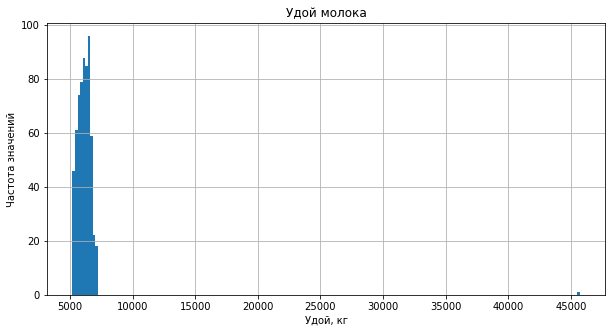

In [19]:
pd.Series(ferma_main['удой_кг']).hist(bins=200, range=(5200,45700))
plt.title ('Удой молока')
plt.xlabel('Удой, кг')
plt.ylabel('Частота значений')
plt.show()

Из графика видим выбросы в данных, выведем их.

In [20]:
ferma_main.query('удой_кг > 10000')

,id,удой_кг,эке_энергетическая_кормовая_единица,сырой_протеин_г,спо_сахаро-протеиновое_соотношение,порода,тип_пастбища,порода_папы_быка,жирность_%,белок_%,вкус_молока,возраст
16,17,45616.0,11.5,1675.0,0.93,Вис Бик Айдиал,Холмистое,Айдиалл,3.22,3.076,вкусно,более_2_лет


Вероятно, здесь закралась опечатка (например, лишняя цифра 4 в начале числа). В реальной жизни можно было бы уточнить информацию у фермера. В текущем пректе предлагаю удалить строку.
После удаления повторим построение гистограммы.

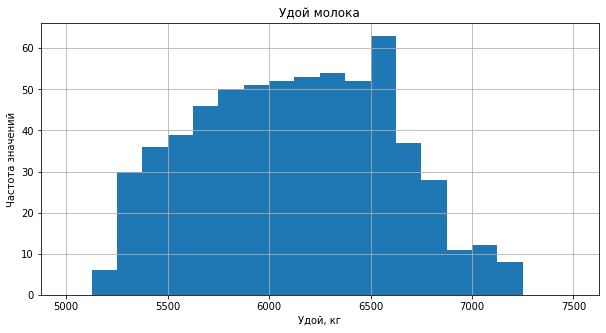

In [21]:
ferma_main = ferma_main.query('удой_кг < 10000')
pd.Series(ferma_main['удой_кг']).hist(bins=20, range=(5000,7500))
plt.title ('Удой молока')
plt.xlabel('Удой, кг')
plt.ylabel('Частота значений')
plt.show()

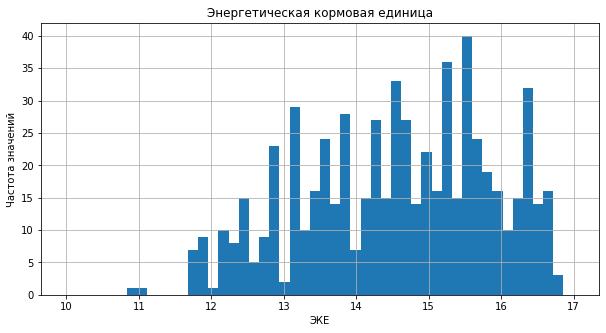

In [22]:
pd.Series(ferma_main['эке_энергетическая_кормовая_единица']).hist(bins=50, range=(10,17))
plt.title ('Энергетическая кормовая единица')
plt.xlabel('ЭКЕ')
plt.ylabel('Частота значений')
plt.show()

In [23]:
ferma_main.query('эке_энергетическая_кормовая_единица < 11')

,id,удой_кг,эке_энергетическая_кормовая_единица,сырой_протеин_г,спо_сахаро-протеиновое_соотношение,порода,тип_пастбища,порода_папы_быка,жирность_%,белок_%,вкус_молока,возраст
581,582,5573.0,10.9,1955.0,0.84,Вис Бик Айдиал,Холмистое,Соверин,3.39,3.079,вкусно,менее_2_лет


Строка выше - это строка, в которой энергетическая кормовая единица меньше порогового нормального минимального значения, но его отличие незначительно, в связи с чем предлагается не удалять строку. 

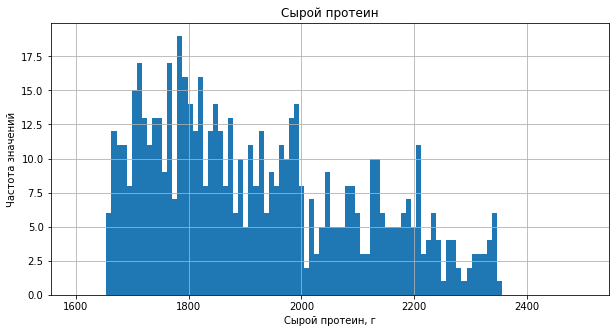

In [24]:
pd.Series(ferma_main['сырой_протеин_г']).hist(bins=100, range=(1600,2500))
plt.title ('Сырой протеин')
plt.xlabel('Сырой протеин, г')
plt.ylabel('Частота значений')
plt.show()

Аномальных данных не зафиксировано.
Можно отметить, что макситмальное значение (2349) немного выше нормального максимального значения (2336), но незначительно.

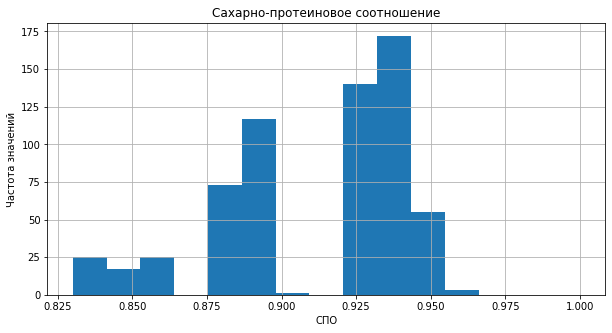

In [25]:
pd.Series(ferma_main['спо_сахаро-протеиновое_соотношение']).hist(bins=15, range=(0.83,1))
plt.title ('Сахарно-протеиновое соотношение')
plt.xlabel('СПО')
plt.ylabel('Частота значений')
plt.show()

Аномальных данных не зафиксировано.

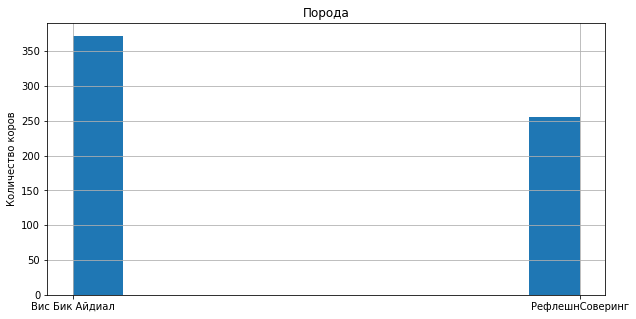

In [26]:
pd.Series(ferma_main['порода']).hist()
plt.title ('Порода')
plt.ylabel('Количество коров')
plt.show()

Для категориальных данных также удобно строить столбчатую диаграмму (она похожа на гистограмму) и круговую диаграмму. Покажу наглядно на этом примере (ниже построены столбчатая и круговая диаграммы).

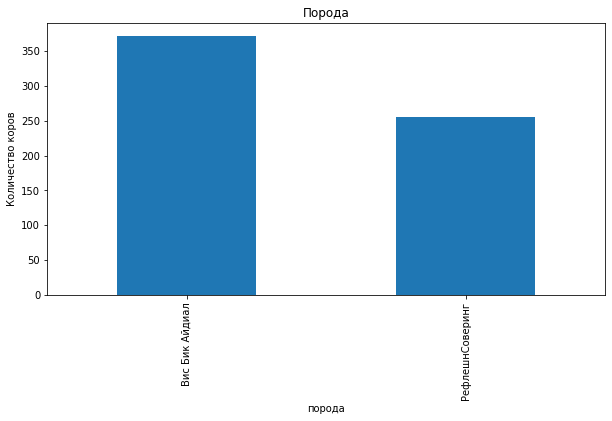

In [27]:
ferma_main.groupby('порода')['порода'].count().plot.bar(title='Порода', xlabel='порода', ylabel='Количество коров')
plt.show()

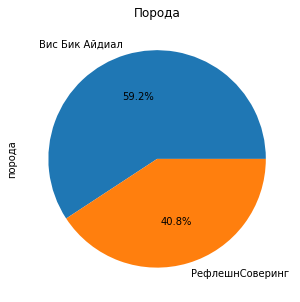

In [28]:
ferma_main.groupby('порода')['порода'].count().plot.pie(title='Порода', autopct='%1.1f%%')
plt.show()

Можем сделать вывод, что коров породы Вис Бик Айдиал больше, чем коров породы РефлешнСоверинг.

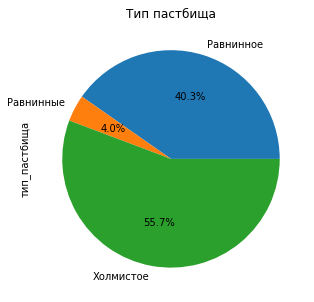

In [29]:
ferma_main.groupby('тип_пастбища')['тип_пастбища'].count().plot.pie(title='Тип пастбища', autopct='%1.1f%%')
plt.show()

На данной гистограмме видим неявные дубликаты в типе пастбищ (равнинные и равнинное).
Заменим значения "Равнинные" на "Равнинное"ти построим диаграмму заново. А также заменим все символы на строчные, так как в файле cow_buy.csv эти значения указаны строчными буквами.

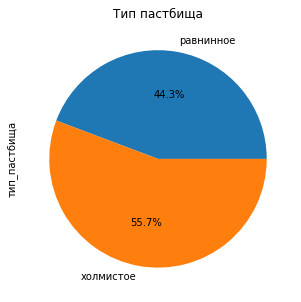

In [30]:
ferma_main['тип_пастбища'] = ferma_main['тип_пастбища'].str.replace('Равнинные', 'Равнинное').str.lower()
ferma_main.groupby('тип_пастбища')['тип_пастбища'].count().plot.pie(title='Тип пастбища', autopct='%1.1f%%')
plt.show()

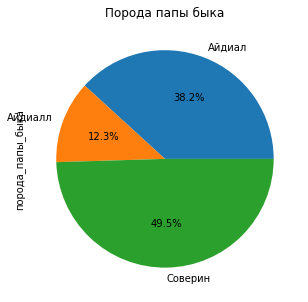

In [31]:
ferma_main.groupby('порода_папы_быка')['порода_папы_быка'].count().plot.pie(title='Порода папы быка', autopct='%1.1f%%')
plt.show()

Аналогично - видим неявные дубликаты. Обработаем их (заменим "Айдиалл" на "Айдиал").

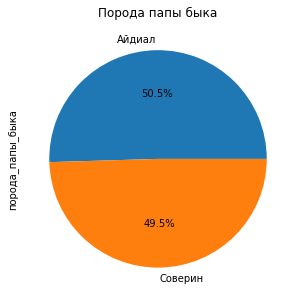

In [32]:
ferma_main['порода_папы_быка'] = ferma_main['порода_папы_быка'].str.replace('Айдиалл', 'Айдиал')
ferma_main.groupby('порода_папы_быка')['порода_папы_быка'].count().plot.pie(title='Порода папы быка', autopct='%1.1f%%')
plt.show()

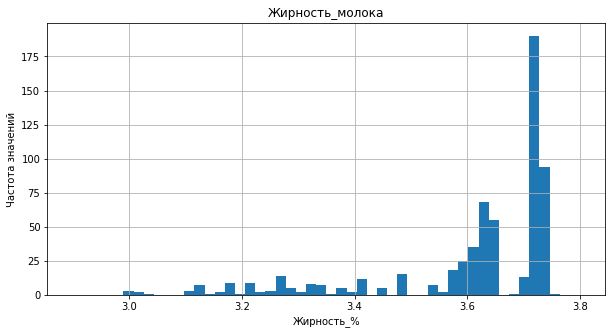

In [33]:
pd.Series(ferma_main['жирность_%']).hist(bins=50, range=(2.9,3.8))
plt.title('Жирность_молока')
plt.xlabel('Жирность_%')
plt.ylabel('Частота значений')
plt.show()

Аномальных данных не зафиксировано.

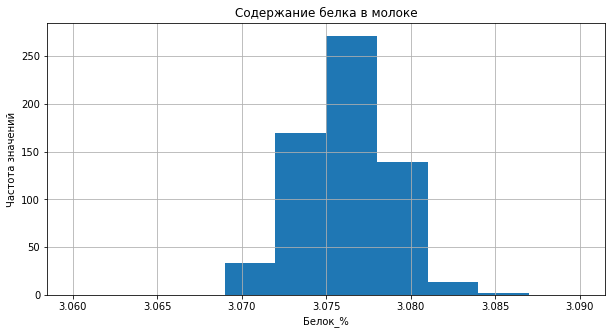

In [34]:
pd.Series(ferma_main['белок_%']).hist(bins=10, range=(3.06,3.09))
plt.title('Содержание белка в молоке')
plt.xlabel('Белок_%')
plt.ylabel('Частота значений')
plt.show()

Аномальных данных не зафиксировано.

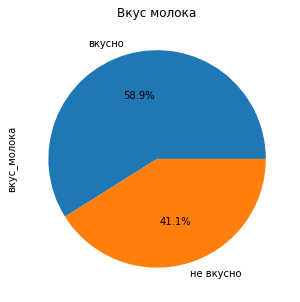

In [35]:
ferma_main.groupby('вкус_молока')['вкус_молока'].count().plot.pie(title='Вкус молока', autopct='%1.1f%%')
plt.show()

Молоко чаще вкусное, чем невкусное :)

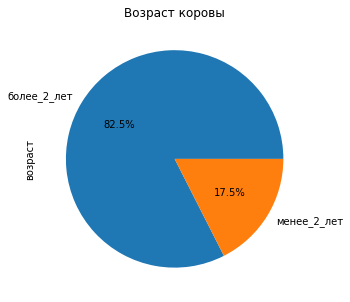

In [36]:
ferma_main.groupby('возраст')['возраст'].count().plot.pie(title='Возраст коровы', autopct='%1.1f%%')
plt.show()

Большинство коров старше двух лет.

### Анализ данных в таблице ferma_dad

Построим график для признака "имя папы".

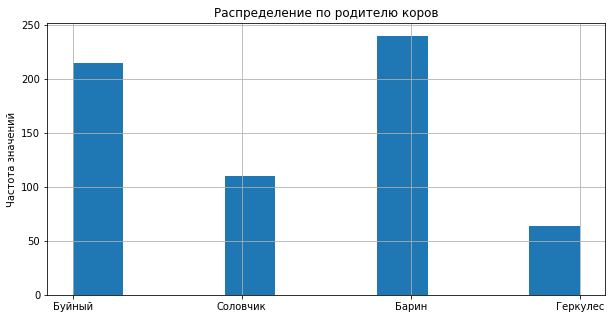

In [37]:
pd.Series(ferma_dad['имя_папы']).hist()
plt.title('Распределение по родителю коров')
plt.ylabel('Частота значений')
plt.show()

Аномальных выбросов не зафиксировано, из гистограммы видим, что всего есть 4 быка-родителя, количество "детей" распределено примерно в одних числовых порядках.

### Анализ данных в таблице cow_buy

Построим графики для каждого признака. Выведем для удобства числовое описание диаграммы размаха, чтобы корректно указывать параметры при построении гистограмм (добавив в таблицу границы нормальных значений).

In [38]:
cow_buy.describe()

info_cow_buy=cow_buy.describe().T
info_cow_buy['norm_min']=info_cow_buy['25%']-1.5*info_cow_buy['std']
info_cow_buy['norm_max']=info_cow_buy['75%']+1.5*info_cow_buy['std']
info_cow_buy

,count,mean,std,min,25%,50%,75%,max,norm_min,norm_max
текущая_жирность_%,20.0,3.5775,0.126818,3.340,3.510,3.590,3.650,3.770,3.319772,3.840228
текущий_уровень_белка_%,20.0,3.0695,0.010339,3.046,3.064,3.074,3.076,3.081,3.048492,3.091508


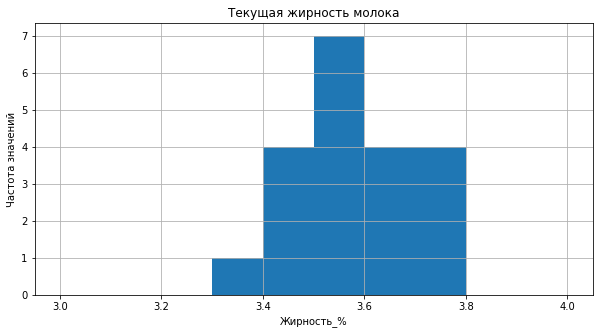

In [39]:
pd.Series(cow_buy['текущая_жирность_%']).hist(bins=10, range=(3,4))
plt.title('Текущая жирность молока')
plt.xlabel('Жирность_%')
plt.ylabel('Частота значений')
plt.show()

Из таблицы и диаграммы видим, что данные "лежат" в границах нормальных значений, аномальных значений не зафиксировано.

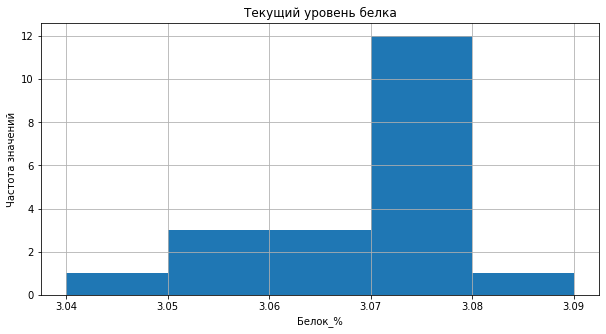

In [40]:
pd.Series(cow_buy['текущий_уровень_белка_%']).hist(bins=5, range=(3.04,3.09))
plt.title('Текущий уровень белка')
plt.xlabel('Белок_%')
plt.ylabel('Частота значений')
plt.show()

Аномальных значений не зафиксировано.

### Промежуточный вывод
На данном этапе мы провели исследовательский анализ данных, который помог выявить аномальные значения в таблицах, а также неявные дубликаты.

## Корреляционный анализ

Рассчитаем коэффициенты корреляции Фи (так как нужно отобразить взаимосвязь между категориальными, порядковыми и интервальными признаками, а корреляция Пирсона не подходит для категориальных признаков). 

In [41]:
ferma_main.drop(columns=['id']).phik_matrix(interval_cols=['удой_кг', 'эке_энергетическая_кормовая_единица', 'сырой_протеин_г', 'спо_сахаро-протеиновое_соотношение', 'жирность_%', 'белок_%']) 

,удой_кг,эке_энергетическая_кормовая_единица,сырой_протеин_г,спо_сахаро-протеиновое_соотношение,порода,тип_пастбища,порода_папы_быка,жирность_%,белок_%,вкус_молока,возраст
удой_кг,1.000000,0.720719,0.463224,0.661359,0.164744,0.279540,0.519915,0.707654,0.058970,0.173122,0.998101
эке_энергетическая_кормовая_единица,0.720719,1.000000,0.456484,0.591190,0.123086,0.106758,0.171355,0.715914,0.000000,0.272265,0.771596
сырой_протеин_г,0.463224,0.456484,1.000000,0.387188,0.090925,0.096474,0.000000,0.397380,0.202474,0.176480,0.351685
спо_сахаро-протеиновое_соотношение,0.661359,0.591190,0.387188,1.000000,0.062660,0.155349,0.425601,0.645581,0.073787,0.572702,0.744410
порода,0.164744,0.123086,0.090925,0.062660,1.000000,0.213218,0.089330,0.222825,0.361851,0.000000,0.057295
тип_пастбища,0.279540,0.106758,0.096474,0.155349,0.213218,1.000000,0.000000,0.000000,0.099908,0.269063,0.128455
порода_папы_быка,0.519915,0.171355,0.000000,0.425601,0.089330,0.000000,1.000000,0.000000,0.134582,0.000000,0.355817
жирность_%,0.707654,0.715914,0.397380,0.645581,0.222825,0.000000,0.000000,1.000000,0.000000,0.198793,0.677913
белок_%,0.058970,0.000000,0.202474,0.073787,0.361851,0.099908,0.134582,0.000000,1.000000,0.143857,0.000000
вкус_молока,0.173122,0.272265,0.176480,0.572702,0.000000,0.269063,0.000000,0.198793,0.143857,1.000000,0.165974


Для наглядности представим коээфициенты в виде тепловой карты, из которой видно, что признаки "удой" и "возраст" имеют высокий коэффициент корреляции. Необходимо это учесть при подготовке данных к обучению.

<AxesSubplot:>

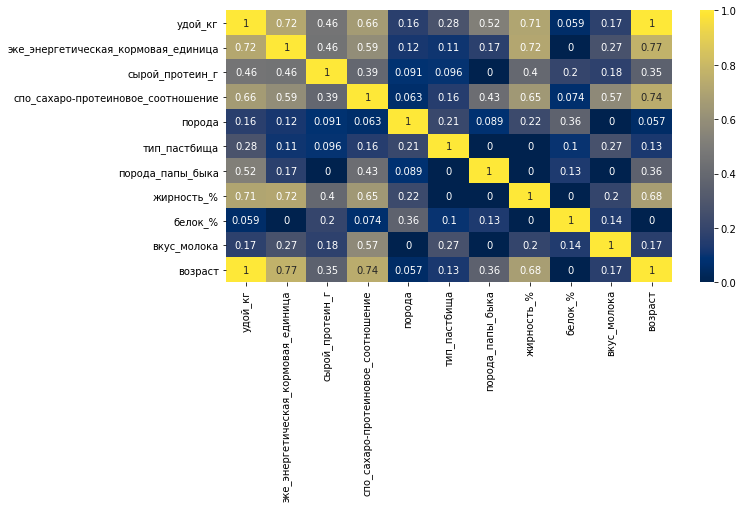

In [42]:
sns.heatmap(ferma_main.drop(columns=['id']).phik_matrix(interval_cols=['удой_кг', 'эке_энергетическая_кормовая_единица', 'сырой_протеин_г', 'спо_сахаро-протеиновое_соотношение', 'жирность_%', 'белок_%']) , annot=True, cmap='cividis') 

Построим диаграммы рассеяния для признака "удой" и всех количественных признаков с учётом значения категориальных признаков. 

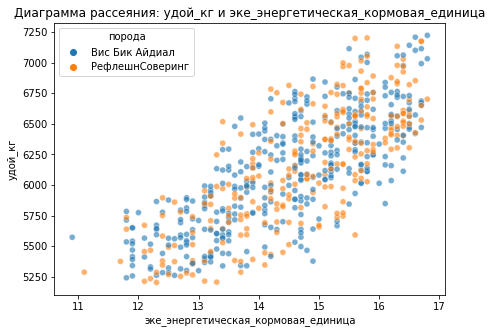

Коэффициент корреляции зависимости удоя от показателя "эке_энергетическая_кормовая_единица": 0.7650977877344268


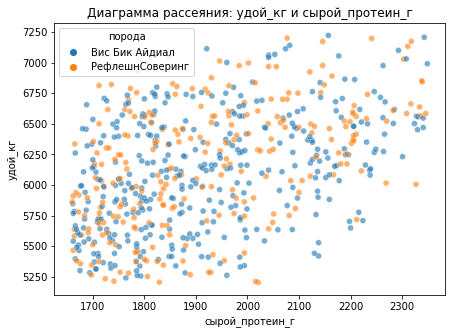

Коэффициент корреляции зависимости удоя от показателя "сырой_протеин_г": 0.4467312546088666


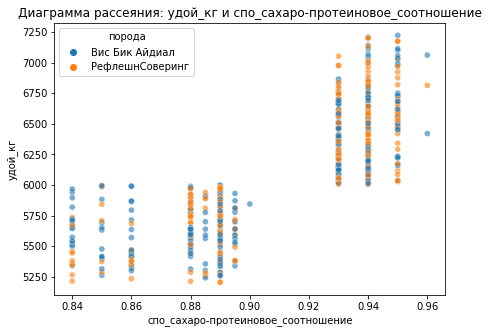

Коэффициент корреляции зависимости удоя от показателя "спо_сахаро-протеиновое_соотношение": 0.8063389252912262


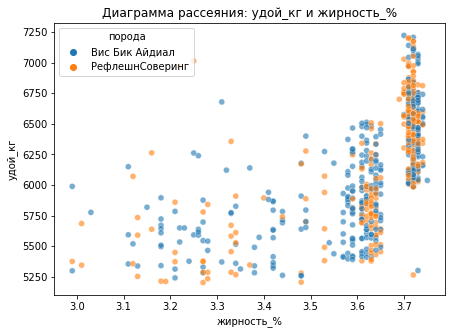

Коэффициент корреляции зависимости удоя от показателя "жирность_%": 0.6009018484316156


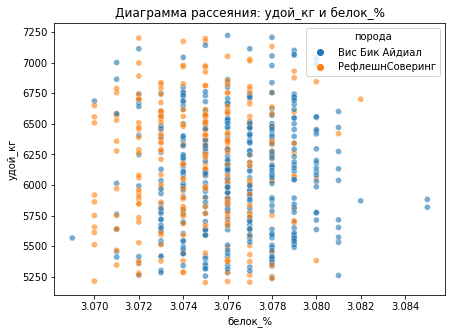

Коэффициент корреляции зависимости удоя от показателя "белок_%": 0.002965710114691232


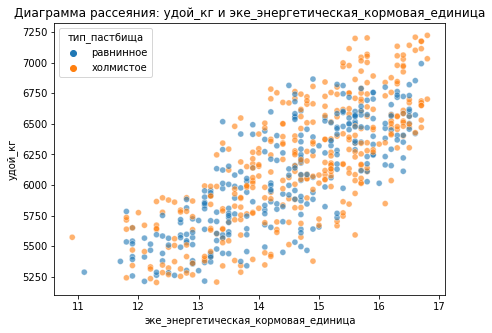

Коэффициент корреляции зависимости удоя от показателя "эке_энергетическая_кормовая_единица": 0.7650977877344268


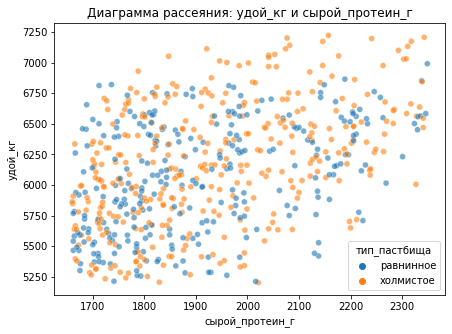

Коэффициент корреляции зависимости удоя от показателя "сырой_протеин_г": 0.4467312546088666


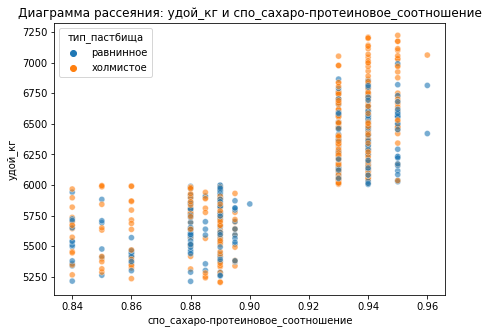

Коэффициент корреляции зависимости удоя от показателя "спо_сахаро-протеиновое_соотношение": 0.8063389252912262


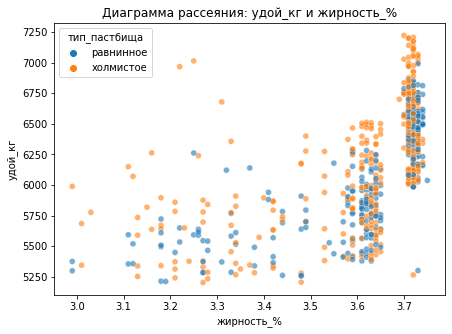

Коэффициент корреляции зависимости удоя от показателя "жирность_%": 0.6009018484316156


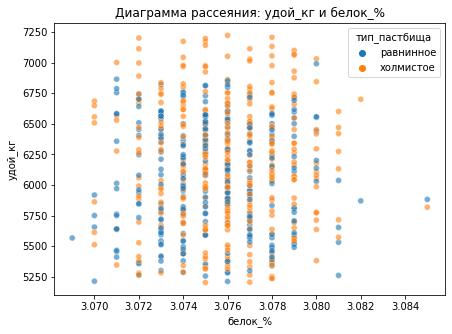

Коэффициент корреляции зависимости удоя от показателя "белок_%": 0.002965710114691232


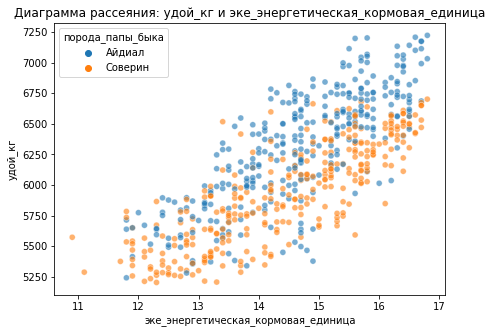

Коэффициент корреляции зависимости удоя от показателя "эке_энергетическая_кормовая_единица": 0.7650977877344268


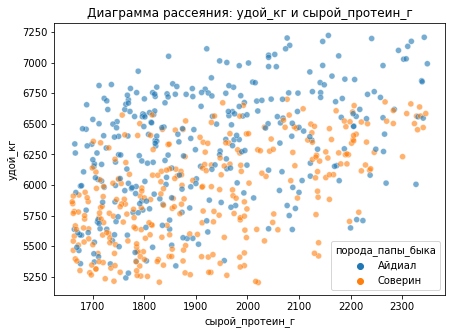

Коэффициент корреляции зависимости удоя от показателя "сырой_протеин_г": 0.4467312546088666


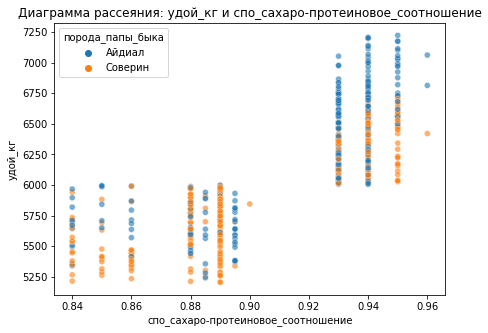

Коэффициент корреляции зависимости удоя от показателя "спо_сахаро-протеиновое_соотношение": 0.8063389252912262


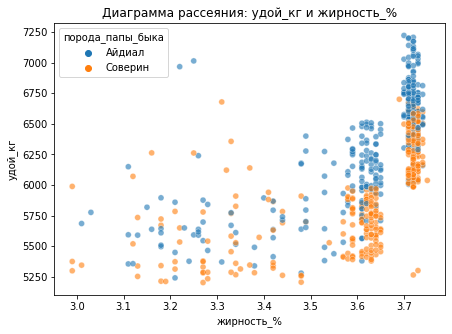

Коэффициент корреляции зависимости удоя от показателя "жирность_%": 0.6009018484316156


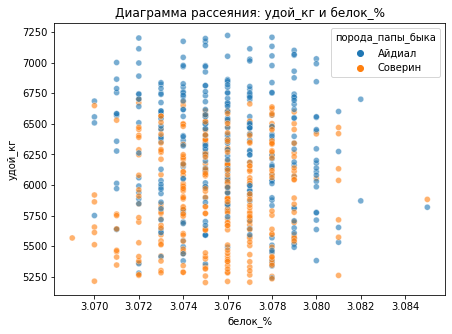

Коэффициент корреляции зависимости удоя от показателя "белок_%": 0.002965710114691232


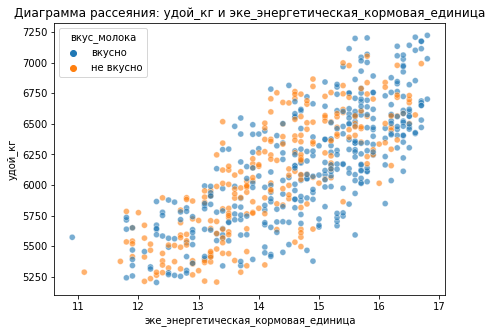

Коэффициент корреляции зависимости удоя от показателя "эке_энергетическая_кормовая_единица": 0.7650977877344268


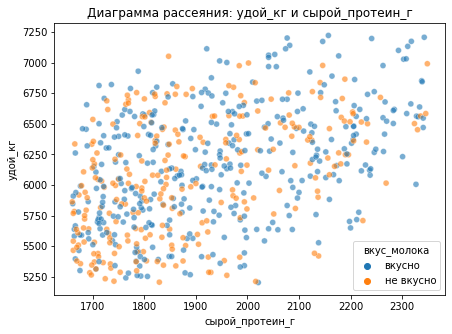

Коэффициент корреляции зависимости удоя от показателя "сырой_протеин_г": 0.4467312546088666


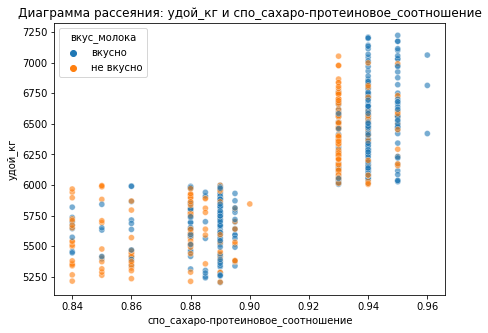

Коэффициент корреляции зависимости удоя от показателя "спо_сахаро-протеиновое_соотношение": 0.8063389252912262


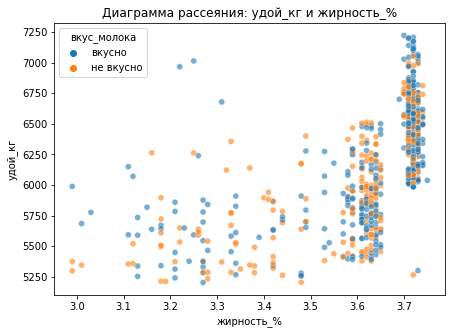

Коэффициент корреляции зависимости удоя от показателя "жирность_%": 0.6009018484316156


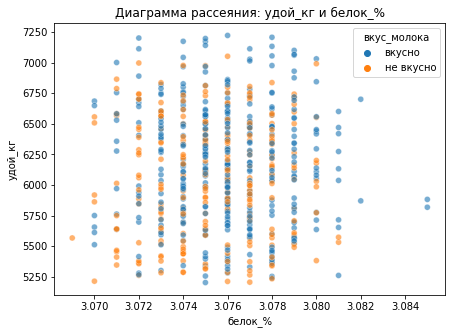

Коэффициент корреляции зависимости удоя от показателя "белок_%": 0.002965710114691232


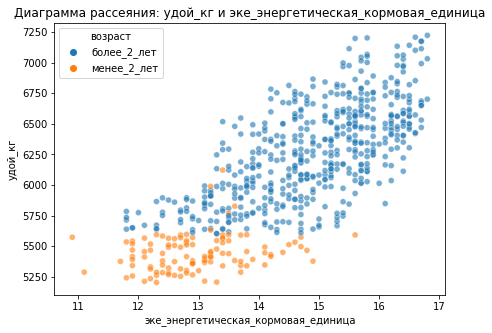

Коэффициент корреляции зависимости удоя от показателя "эке_энергетическая_кормовая_единица": 0.7650977877344268


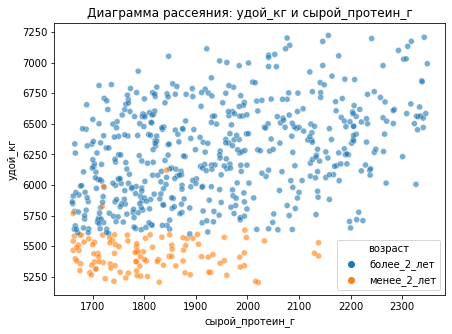

Коэффициент корреляции зависимости удоя от показателя "сырой_протеин_г": 0.4467312546088666


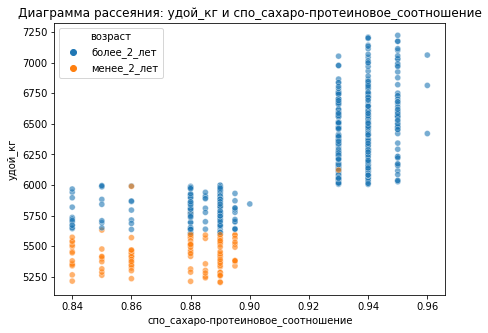

Коэффициент корреляции зависимости удоя от показателя "спо_сахаро-протеиновое_соотношение": 0.8063389252912262


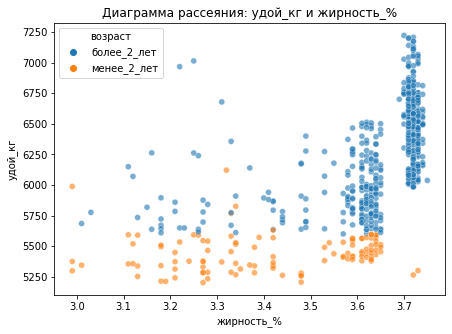

Коэффициент корреляции зависимости удоя от показателя "жирность_%": 0.6009018484316156


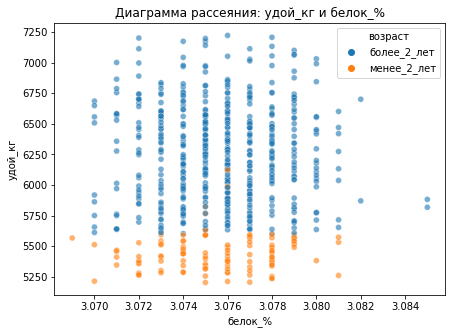

Коэффициент корреляции зависимости удоя от показателя "белок_%": 0.002965710114691232


In [43]:
# Список количественных признаков
quantitative_features = ['эке_энергетическая_кормовая_единица', 'сырой_протеин_г', 'спо_сахаро-протеиновое_соотношение', 'жирность_%', 'белок_%']

# Список категориальных признаков и расчет коэффициентов корреляции
categorical_features = ['порода', 'тип_пастбища', 'порода_папы_быка', 'вкус_молока', 'возраст']

# Создание диаграмм рассеяния
for category in categorical_features:
    for quantity in quantitative_features:
        plt.figure(figsize=(7, 5))
        sns.scatterplot(data=ferma_main, alpha=0.6, x=quantity, y='удой_кг', hue=category)
        plt.title(f'Диаграмма рассеяния: удой_кг и {quantity}')
        plt.xlabel(quantity)
        plt.ylabel('удой_кг')
        plt.legend(title=category)
        plt.show()
        print(f'Коэффициент корреляции зависимости удоя от показателя "{quantity}":', ferma_main['удой_кг'].corr(ferma_main[quantity]))


### Промежуточный вывод

В последующем нам предстоит решить две задачи - задачу регрессии (где целевым показателем будет удой) и задачу классификации (где целевым показателем будет вкус молока).
По построенным диаграммам рассеяния и рассчитанным коэффициентам корреляции можно сделать следующие выводы о взаимосвязи признаков:
 - присутствуют как линейный, так и нелинейный тип связи между целевым и входными признаками
 - нелинейный тип связи потребует дополнительной обработки данных
 - также присутствует мультиколлинеарность между входными признаками для второй задачи (возраст и удой), что также потребует дополнительной обработки данных

## Обучение модели линейной регрессии

### Подготовим данные датасета ferma_main и обучим на них первую модель LinearRegression

Целевой параметр - удой_кг.

На данном этапе возьмем в качестве входных параметров:
 - те, у которых имеется линейная связь с целевым параметром (удой_кг): эке_энергетическая_кормовая_единица
 - те, что логически могут иметь причинно-следственные связи между удоем коров и группами признаков:
         - характеристики коровы: порода, порода_папы_быка, возраст
         - характеристики корма: эке_энергетическая_кормовая_единица, сырой_протеин_г, спо_сахаро_протеиновое_соотношение
         - характеристика пастбища: тип_пастбища.

In [44]:
ferma_main.head()

,id,удой_кг,эке_энергетическая_кормовая_единица,сырой_протеин_г,спо_сахаро-протеиновое_соотношение,порода,тип_пастбища,порода_папы_быка,жирность_%,белок_%,вкус_молока,возраст
0,1,5863.0,14.2,1743.0,0.890,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529.0,12.8,2138.0,0.890,Вис Бик Айдиал,равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810.0,14.0,1854.0,0.885,РефлешнСоверинг,холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895.0,12.4,2012.0,0.885,РефлешнСоверинг,холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302.0,12.8,1675.0,0.885,Вис Бик Айдиал,равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет


X_train_1 = (471, 7)
X_test_1 = (157, 7)
R2 LinearRegression = 0.7844078173416967
Среднее значение остатков = -25.37328620820106


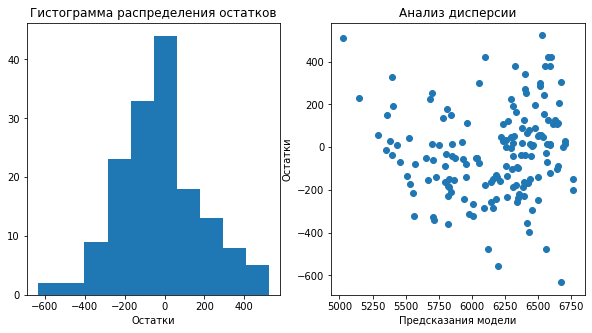

In [45]:
# отбираем входные признаки
X_1 = ferma_main[['эке_энергетическая_кормовая_единица', 'сырой_протеин_г', 'спо_сахаро-протеиновое_соотношение', 'порода', 'тип_пастбища', 'порода_папы_быка', 'возраст']]
# определяем целевой признак
y_1 = ferma_main['удой_кг']

categorical_features_1 = ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст']
quantitative_features_1 = ['эке_энергетическая_кормовая_единица', 'сырой_протеин_г', 'спо_сахаро-протеиновое_соотношение']

# функция обучения модели, включая кодировку категориальных признаков и масштабирование количественных признаков
def model_training (X, y, categorical_features, quantitative_features):
    # разбиваем данные на тренировочную и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE
    )

    # кодируем категориальные признаки с помощью OneHotEncoder
    encoder  = OneHotEncoder (drop='first', sparse_output=False, handle_unknown='ignore')
    # categorical_features = ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст']
    X_train_ohe = encoder.fit_transform(X_train[categorical_features]) 
    X_test_ohe = encoder.transform(X_test[categorical_features]) 

    X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder.get_feature_names_out() )
    X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder.get_feature_names_out())

    # масштабируем количественные признаки с помощью StandardScaler
    scaler = StandardScaler()
    #quantitative_features = ['эке_энергетическая_кормовая_единица', 'сырой_протеин_г', 'спо_сахаро-протеиновое_соотношение']
    X_train_scaler = scaler.fit_transform(X_train[quantitative_features])
    X_test_scaler = scaler.transform(X_test[quantitative_features])

    X_train_scaler = pd.DataFrame(X_train_scaler, columns=quantitative_features)
    X_test_scaler = pd.DataFrame(X_test_scaler, columns=quantitative_features)

    # Объединим полученные данные
    X_train = pd.concat([X_train_scaler, X_train_ohe], axis=1)
    X_test = pd.concat([X_test_scaler, X_test_ohe], axis=1)

    # Обучим модель линейной регрессии на подготовленных данных
    model_lr = LinearRegression()
    model_lr.fit(X_train, y_train)

    # получим предсказания модели на тестовых данных 
    predictions = model_lr.predict(X_test)
    return X_train, X_test, y_train, y_test, predictions, model_lr, encoder, scaler

X_train_1, X_test_1, y_train_1, y_test_1, predictions_1, model_lr_1, encoder_1, scaler_1 = model_training (X_1, y_1, categorical_features_1, quantitative_features_1)
print ("X_train_1 =", X_train_1.shape)
print ("X_test_1 =", X_test_1.shape)

# функция расчета и визуализации R2
def R2(y_test, predictions):
    # рассчитаем и выведем значения R2 для линейной регрессии
    r2 = r2_score(y_test, predictions)  
    print("R2 LinearRegression =", r2)

    # проанализируем остатки с помощью графиков
    # построим графики по количественным признакам — гистограмму частотности распределения и диаграмму рассеяния

    residuals = y_test - predictions
    print("Среднее значение остатков =", residuals.mean())

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    axes[0].hist(residuals)
    axes[0].set_title('Гистограмма распределения остатков')
    axes[0].set_xlabel('Остатки')

    axes[1].scatter(x=predictions, y=residuals)
    axes[1].set_xlabel('Предсказания модели')
    axes[1].set_ylabel('Остатки')
    axes[1].set_title('Анализ дисперсии')
    plt.show()

R2(y_test_1, predictions_1)


На основании полученных данных можно сделать следующие выводы:
 - значение R² модели = 0.78 (то есть модель ошибается примерно в 22% случаях, есть, к чему стремиться);
 - гистограмма распределения остатков показывает ассиметричное нормальное распределение со смешением влево (Среднее значение остатков = -25.37). Это говорит о том, что модель часто даёт слишком большие предсказания, её прогнозы больше истинных значений;
 - остатки на диаграмме показывают, что модель может работать неустойчиво, поскольку разброс остатков непостоянен. 

Проведем дополнительные исследования и повторим обучение модели на доработанных данных.

### Подготовим данные с учётом связи входных признаков с целевым и обучим на них вторую модель LinearRegression

На графиках выше видно, что СПО и удой связаны нелинейно. На их диаграмме рассеяния наблюдения сгруппированы в два кластера, причём есть такое значение СПО, которое можно считать границей между кластерами. Чтобы устранить нелинейность, преобразуем СПО в категориальный бинарный признак, использовав эту границу.

In [46]:
# определим границу СПО по графику
boundary = 0.9

# создадим новый бинарный признак на основе границы СПО
ferma_main['спо_категория'] = (ferma_main['спо_сахаро-протеиновое_соотношение'] > boundary).astype(int)

ЭКЕ и Удой также связаны нелинейно. Нелинейность между ними можно исключить, если ввести новый признак 'эке_в_квадрате'.

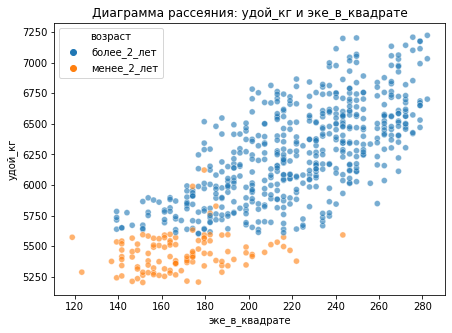

Коэффициент корреляции зависимости удоя от показателя "белок_%": 0.7655300782523312


In [47]:
ferma_main['эке_в_квадрате']=ferma_main['эке_энергетическая_кормовая_единица']**2
plt.figure(figsize=(7, 5))
sns.scatterplot(data=ferma_main, alpha=0.6, x='эке_в_квадрате', y='удой_кг', hue=category)
plt.title(f'Диаграмма рассеяния: удой_кг и эке_в_квадрате')
plt.xlabel('эке_в_квадрате')
plt.ylabel('удой_кг')
plt.legend(title=category)
plt.show()
print(f'Коэффициент корреляции зависимости удоя от показателя "{quantity}":', ferma_main['удой_кг'].corr(ferma_main['эке_в_квадрате']))


Повторим шаги по обучению модели.

R2 LinearRegression = 0.8180879926867504
Среднее значение остатков = -24.372798135532236


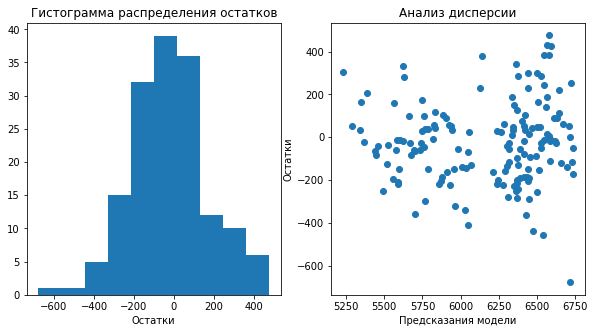

In [48]:
# отбираем входные признаки
X_2 = ferma_main[['эке_в_квадрате', 'сырой_протеин_г', 'спо_категория', 'порода', 'тип_пастбища', 'порода_папы_быка', 'возраст']]
# определяем целевой признак
y_2 = ferma_main['удой_кг']

categorical_features_2 = ['спо_категория', 'порода', 'тип_пастбища', 'порода_папы_быка', 'возраст']
quantitative_features_2 = ['эке_в_квадрате', 'сырой_протеин_г']

X_train_2, X_test_2, y_train_2, y_test_2, predictions_2, model_lr_2, encoder_2, scaler_2 = model_training (X_2, y_2, categorical_features_2, quantitative_features_2)

R2(y_test_2, predictions_2)


На основании полученных данных можно сделать следующие выводы:
 - значение R² модели улучшилось = 0.81 (то есть модель ошибается примерно в 19% случаях);
 - гистограмма распределения остатков показывает ассиметричное нормальное распределение со смешением влево (Среднее значение остатков = -24.37). Это говорит о том, что модель часто даёт слишком большие предсказания, её прогнозы больше истинных значений;
 - разброс остатков теперь распределен равномернее, то есть модель стала устойчивее.

Проведем дополнительные исследования и повторим обучение модели на доработанных данных.

### Добавим в данные новый признак и обучим на них третью модель LinearRegression

Добавим признак 'имя_папы' из файла ferma_dad.csv, соединив его с остальными данными ferma_main.csv по ключу.

In [49]:
print ("shape_ferma_main_before", ferma_main.shape)
ferma_main = pd.merge(ferma_main, ferma_dad, on='id')
print ("shape_ferma_main_after", ferma_main.shape)
ferma_main.head()

shape_ferma_main_before (628, 14)
shape_ferma_main_after (628, 15)


,id,удой_кг,эке_энергетическая_кормовая_единица,сырой_протеин_г,спо_сахаро-протеиновое_соотношение,порода,тип_пастбища,порода_папы_быка,жирность_%,белок_%,вкус_молока,возраст,спо_категория,эке_в_квадрате,имя_папы
0,1,5863.0,14.2,1743.0,0.890,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,0,201.64,Буйный
1,2,5529.0,12.8,2138.0,0.890,Вис Бик Айдиал,равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,0,163.84,Соловчик
2,3,5810.0,14.0,1854.0,0.885,РефлешнСоверинг,холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,0,196.00,Барин
3,4,5895.0,12.4,2012.0,0.885,РефлешнСоверинг,холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,0,153.76,Буйный
4,5,5302.0,12.8,1675.0,0.885,Вис Бик Айдиал,равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,0,163.84,Барин


In [50]:
ferma_main.drop(columns=['id']).phik_matrix(interval_cols=['удой_кг', 'эке_энергетическая_кормовая_единица', 'сырой_протеин_г', 'спо_сахаро-протеиновое_соотношение', 'жирность_%', 'белок_%']) 

,удой_кг,эке_энергетическая_кормовая_единица,сырой_протеин_г,спо_сахаро-протеиновое_соотношение,порода,тип_пастбища,порода_папы_быка,жирность_%,белок_%,вкус_молока,возраст,спо_категория,эке_в_квадрате,имя_папы
удой_кг,1.000000,0.720719,0.463224,0.661359,0.164744,0.279540,0.519915,0.707654,0.058970,0.173122,0.998101,0.999947,0.687767,0.433409
эке_энергетическая_кормовая_единица,0.720719,1.000000,0.456484,0.591190,0.123086,0.106758,0.171355,0.715914,0.000000,0.272265,0.771596,0.900428,1.000000,0.069197
сырой_протеин_г,0.463224,0.456484,1.000000,0.387188,0.090925,0.096474,0.000000,0.397380,0.202474,0.176480,0.351685,0.537071,0.354411,0.111229
спо_сахаро-протеиновое_соотношение,0.661359,0.591190,0.387188,1.000000,0.062660,0.155349,0.425601,0.645581,0.073787,0.572702,0.744410,1.000000,0.687535,0.409142
порода,0.164744,0.123086,0.090925,0.062660,1.000000,0.213218,0.089330,0.222825,0.361851,0.000000,0.057295,0.028933,0.154443,0.382644
тип_пастбища,0.279540,0.106758,0.096474,0.155349,0.213218,1.000000,0.000000,0.000000,0.099908,0.269063,0.128455,0.143022,0.122001,0.233149
порода_папы_быка,0.519915,0.171355,0.000000,0.425601,0.089330,0.000000,1.000000,0.000000,0.134582,0.000000,0.355817,0.407797,0.092416,0.982909
жирность_%,0.707654,0.715914,0.397380,0.645581,0.222825,0.000000,0.000000,1.000000,0.000000,0.198793,0.677913,0.922373,0.760678,0.090409
белок_%,0.058970,0.000000,0.202474,0.073787,0.361851,0.099908,0.134582,0.000000,1.000000,0.143857,0.000000,0.000000,0.000000,0.091102
вкус_молока,0.173122,0.272265,0.176480,0.572702,0.000000,0.269063,0.000000,0.198793,0.143857,1.000000,0.165974,0.100949,0.253971,0.000000


<AxesSubplot:>

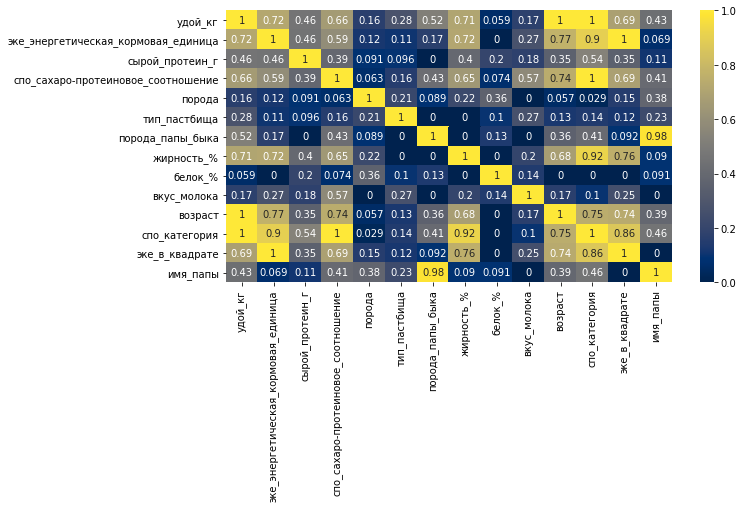

In [51]:
sns.heatmap(ferma_main.drop(columns=['id']).phik_matrix(interval_cols=['удой_кг', 'эке_энергетическая_кормовая_единица', 'сырой_протеин_г', 'спо_сахаро-протеиновое_соотношение', 'жирность_%', 'белок_%']), annot=True, cmap='cividis') 

Получается, теперь во входных признаках есть мультиколлинеарность - имя_папы однозначно определяет породу папы, оставим только один из этих двух параметров (имя_папы_быка). и снова обучим модель.

R2 LinearRegression = 0.8265123645098966
Среднее значение остатков = -17.11851276803253


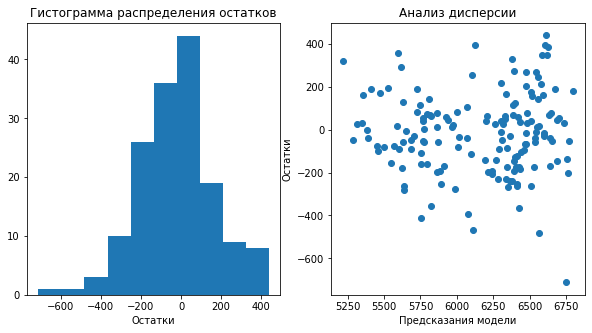

In [52]:
# отбираем входные признаки
X_3 = ferma_main[['эке_в_квадрате', 'сырой_протеин_г', 'спо_категория', 'порода', 'тип_пастбища', 'имя_папы', 'возраст']]
# определяем целевой признак
y_3 = ferma_main['удой_кг']

categorical_features_3 = ['спо_категория', 'порода', 'тип_пастбища', 'имя_папы', 'возраст']
quantitative_features_3 = ['эке_в_квадрате', 'сырой_протеин_г']

X_train_3, X_test_3, y_train_3, y_test_3, predictions_3, model_lr_3, encoder_3, scaler_3 = model_training (X_3, y_3, categorical_features_3, quantitative_features_3)

R2(y_test_3, predictions_3)


На основании полученных данных можно сделать следующие выводы:
 - значение R² модели еще улучшилось = 0.83 (то есть модель ошибается примерно в 17% случаях);
 - смещение влево гистограммы распределения стало ближе к нулю (-17.11) (составляет показывает ассиметричное нормальное распределение со смешением влево (Среднее значение остатков = -24.37);
 - в части разброса остатков ситуация примерно осталась прежней.

### Оценим качество каждой модели по трём метрикам: MSE, MAE, RMSE

In [53]:
MSE_1 = mean_squared_error(y_test_1, predictions_1)
print(f'MSE_1 = {MSE_1}')
MSE_2 = mean_squared_error(y_test_2, predictions_2)
print(f'MSE_2 = {MSE_2}')
MSE_3 = mean_squared_error(y_test_3, predictions_3)
print(f'MSE_3 = {MSE_3} \n')

MAE_1 = mean_absolute_error(y_test_1, predictions_1)
print(f'MAE_1 = {MAE_1}')
MAE_2 = mean_absolute_error(y_test_2, predictions_2)
print(f'MAE_1 = {MAE_2}')
MAE_3 = mean_absolute_error(y_test_3, predictions_3)
print(f'MAE_3 = {MAE_3} \n')

# почему-то после обновление библиотеки "ругается" на предыдущий расчет RMSE, добавила вручную
#RMSE_1 = mean_squared_error(y_test_1, predictions_1, squared=False)
RMSE_1 = np.sqrt(MSE_1)
print(f'RMSE_1 = {RMSE_1}')
#RMSE_2 = mean_squared_error(y_test_2, predictions_2, squared=False)
RMSE_2 = np.sqrt(MSE_2)
print(f'RMSE_2 = {RMSE_2}')
#RMSE_3 = mean_squared_error(y_test_3, predictions_3, squared=False)
RMSE_3 = np.sqrt(MSE_3)
print(f'RMSE_3 = {RMSE_3}')

MSE_1 = 43887.015009660514
MSE_2 = 37030.91131113693
MSE_3 = 35316.00436000986 

MAE_1 = 164.24194463474925
MAE_1 = 149.03965222364602
MAE_3 = 144.63813704526862 

RMSE_1 = 209.4922791170608
RMSE_2 = 192.43417396901447
RMSE_3 = 187.92552876075635


По всем трем метрикам третья модель показывает себя лучше остальных. 

Необходимо указать доверительный интервал прогноза лучшей модели. Для этого рассчитаем квантили ошибки модели на тренировочных данных.

In [54]:
residuals = y_test_3 - predictions_3
# рассчитаем квантили ошибок и стандартное отклонение
lower_quantile_error = np.percentile(residuals, 25)
upper_quantile_error = np.percentile(residuals, 75)
std_error = residuals.std()

# рассчитаем пределы нормальных значений ошибок
norm_interval_error = (lower_quantile_error - 1.5*std_error, upper_quantile_error + 1.5*std_error)
print("Пределы нормальных значений ошибок:", norm_interval_error)

# рассчитаем среднее значение предсказаний
mean_prediction_3 = np.mean(predictions_3)
print (mean_prediction_3)

print("Доверительный интервал предсказаний:", mean_prediction_3 - (lower_quantile_error - 1.5*std_error), mean_prediction_3 + (upper_quantile_error + 1.5*std_error))
residuals.describe()


Пределы нормальных значений ошибок: (-421.09277272426755, 358.43511444118906)
6158.774563723447
Доверительный интервал предсказаний: 6579.8673364477145 6517.209678164636


count    157.000000
mean     -17.118513
std      187.743088
min     -711.976902
25%     -139.478141
50%      -15.817371
75%       76.820483
max      438.780151
Name: удой_кг, dtype: float64

### Спрогнозируем с ее помощью удой коров, которых фермер хочет купить. Данные о них находятся в датасете cow_buy

Добавим недостающие признаки: ЭКЕ (Энергетическая кормовая единица), Сырой протеин, г и СПО (Сахаро-протеиновое соотношение), для этого возьмем из датасета ferma_main средние значения каждого из признаков и увеличим их на 5% (по условиям задачи, технологи заказчика пересмотрели подход к кормлению: для новых коров планируется увеличить значения каждого из этих параметров на 5%).
Также сразу добавим столбцы "спо_категория" и "эке_в_квадрате".

In [55]:
cow_buy

,порода,тип_пастбища,порода_папы_быка,имя_папы,текущая_жирность_%,текущий_уровень_белка_%,возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет


In [56]:
cow_buy['эке_энергетическая_кормовая_единица'] = ferma_main['эке_энергетическая_кормовая_единица'].mean()*1.05
cow_buy['спо_сахаро-протеиновое_соотношение'] = ferma_main['спо_сахаро-протеиновое_соотношение'].mean()*1.05
cow_buy['сырой_протеин_г'] = ferma_main['сырой_протеин_г'].mean()*1.05
cow_buy['спо_категория'] = (cow_buy['спо_сахаро-протеиновое_соотношение'] > boundary).astype(int)
cow_buy['эке_в_квадрате']=cow_buy['эке_энергетическая_кормовая_единица']**2
cow_buy

,порода,тип_пастбища,порода_папы_быка,имя_папы,текущая_жирность_%,текущий_уровень_белка_%,возраст,эке_энергетическая_кормовая_единица,спо_сахаро-протеиновое_соотношение,сырой_протеин_г,спо_категория,эке_в_квадрате
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,0.958744,2019.947532,1,233.361138
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,15.276162,0.958744,2019.947532,1,233.361138
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276162,0.958744,2019.947532,1,233.361138
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.276162,0.958744,2019.947532,1,233.361138
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.276162,0.958744,2019.947532,1,233.361138
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,15.276162,0.958744,2019.947532,1,233.361138
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,0.958744,2019.947532,1,233.361138
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,15.276162,0.958744,2019.947532,1,233.361138
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276162,0.958744,2019.947532,1,233.361138
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,15.276162,0.958744,2019.947532,1,233.361138


In [57]:
X = cow_buy[['эке_в_квадрате', 'сырой_протеин_г', 'спо_категория', 'порода', 'тип_пастбища', 'имя_папы', 'возраст']]

X_ohe = encoder_3.transform(X[categorical_features_3]) 
X_ohe = pd.DataFrame(X_ohe, columns=encoder_3.get_feature_names_out())
X_scaler = scaler_3.transform(X[quantitative_features_3])
X_scaler = pd.DataFrame(X_scaler, columns=quantitative_features_3)
X = pd.concat([X_scaler, X_ohe], axis=1)

predictions_new = model_lr_3.predict(X)
predictions_new


array([6608.4436148 , 6334.2750642 , 6281.14019437, 6592.02787405,
       6543.0287752 , 6380.16736962, 6608.4436148 , 6528.29049287,
       6281.14019437, 6398.01244538, 6338.84415111, 6574.18279829,
       6608.4436148 , 6121.38558222, 6281.14019437, 6592.02787405,
       6338.84415111, 6380.16736962, 6528.29049287, 6543.0287752 ])

Добавим эти значения новым столбцов и отсортируем в порядке убывания для нагладности.

In [58]:
cow_buy ['предсказанный_удой'] = predictions_new
cow_buy.sort_values(by='предсказанный_удой', ascending=False)

,порода,тип_пастбища,порода_папы_быка,имя_папы,текущая_жирность_%,текущий_уровень_белка_%,возраст,эке_энергетическая_кормовая_единица,спо_сахаро-протеиновое_соотношение,сырой_протеин_г,спо_категория,эке_в_квадрате,предсказанный_удой
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,0.958744,2019.947532,1,233.361138,6608.443615
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,0.958744,2019.947532,1,233.361138,6608.443615
12,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.68,3.046,более_2_лет,15.276162,0.958744,2019.947532,1,233.361138,6608.443615
15,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.065,более_2_лет,15.276162,0.958744,2019.947532,1,233.361138,6592.027874
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.276162,0.958744,2019.947532,1,233.361138,6592.027874
11,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.73,3.073,более_2_лет,15.276162,0.958744,2019.947532,1,233.361138,6574.182798
19,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.276162,0.958744,2019.947532,1,233.361138,6543.028775
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.276162,0.958744,2019.947532,1,233.361138,6543.028775
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,15.276162,0.958744,2019.947532,1,233.361138,6528.290493
18,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.34,3.069,более_2_лет,15.276162,0.958744,2019.947532,1,233.361138,6528.290493


### Промежуточный вывод
На данном этапе работ мы построили три модели линейной регрессии, выбрали лучшую из них и. на ее основе спрогнозировали показатель "удой_кг".

## Обучение модели логистической регрессии

### Подготовим данные датасета ferma_main.csv и обучим на них модель LogisticRegression

In [59]:
ferma_main.head()

,id,удой_кг,эке_энергетическая_кормовая_единица,сырой_протеин_г,спо_сахаро-протеиновое_соотношение,порода,тип_пастбища,порода_папы_быка,жирность_%,белок_%,вкус_молока,возраст,спо_категория,эке_в_квадрате,имя_папы
0,1,5863.0,14.2,1743.0,0.890,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,0,201.64,Буйный
1,2,5529.0,12.8,2138.0,0.890,Вис Бик Айдиал,равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,0,163.84,Соловчик
2,3,5810.0,14.0,1854.0,0.885,РефлешнСоверинг,холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,0,196.00,Барин
3,4,5895.0,12.4,2012.0,0.885,РефлешнСоверинг,холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,0,153.76,Буйный
4,5,5302.0,12.8,1675.0,0.885,Вис Бик Айдиал,равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,0,163.84,Барин


Теперь проанализируем данные с учетом того, что целевым показателем будет вкус молока. Логично предположить, что вкус молока может зависить от коровы, того, что она ест, а также показателей жирности и белка.

accuracy = 0.6114649681528662
recall = 0.8522727272727273
precision = 0.6097560975609756


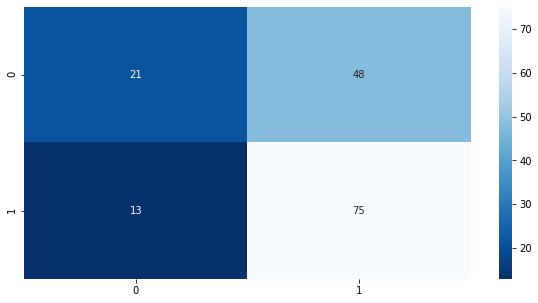

In [60]:


# отбираем входные признаки
X_clf = ferma_main[['эке_энергетическая_кормовая_единица', 'сырой_протеин_г', 'спо_сахаро-протеиновое_соотношение', 'порода', 'тип_пастбища', 'имя_папы', 'возраст', 'жирность_%', 'белок_%']]

# определяем целевой признак
y_clf = ferma_main['вкус_молока']


categorical_features_clf = ['порода', 'тип_пастбища', 'имя_папы', 'возраст']
quantitative_features_clf = ['эке_энергетическая_кормовая_единица', 'сырой_протеин_г', 'спо_сахаро-протеиновое_соотношение', 'жирность_%', 'белок_%']

# разбиваем данные на тренировочную и тестовую выборки
X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(
    X_clf, 
    y_clf, 
    random_state=RANDOM_STATE
    )

# кодируем категориальные признаки с помощью OneHotEncoder
encoder_clf = OneHotEncoder (drop='first', sparse_output=False, handle_unknown='ignore')
X_clf_train_ohe = encoder_clf.fit_transform(X_clf_train[categorical_features_clf]) 
X_clf_test_ohe = encoder_clf.transform(X_clf_test[categorical_features_clf]) 
X_clf_train_ohe = pd.DataFrame(X_clf_train_ohe, columns=encoder_clf.get_feature_names_out())
X_clf_test_ohe = pd.DataFrame(X_clf_test_ohe, columns=encoder_clf.get_feature_names_out())

# масштабируем количественные признаки с помощью StandardScaler
scaler_clf = StandardScaler()
X_clf_train_scaler = scaler_clf.fit_transform(X_clf_train[quantitative_features_clf])
X_clf_test_scaler = scaler_clf.transform(X_clf_test[quantitative_features_clf])

X_clf_train_scaler = pd.DataFrame(X_clf_train_scaler, columns=quantitative_features_clf)
X_clf_test_scaler = pd.DataFrame(X_clf_test_scaler, columns=quantitative_features_clf)

# Объединим полученные данные
X_clf_train = pd.concat([X_clf_train_scaler, X_clf_train_ohe], axis=1)
X_clf_test = pd.concat([X_clf_test_scaler, X_clf_test_ohe], axis=1)

# Обучим модель логистической регрессии на подготовленных данных
model_clf = LogisticRegression()
model_clf.fit(X_clf_train, y_clf_train)

# получим предсказания модели на тестовых данных 
predictions_clf = model_clf.predict(X_clf_test)

# посчитаем метрики accuracy, precision, recall

accuracy = accuracy_score(y_clf_test, predictions_clf)
print(f'accuracy = {accuracy}')
recall = recall_score(y_clf_test, predictions_clf, pos_label='вкусно')
print(f'recall = {recall}')
precision = precision_score(y_clf_test, predictions_clf, pos_label='вкусно')  
print(f'precision = {precision}')

# построим матрицу ошибок
cm = confusion_matrix(y_clf_test, predictions_clf, labels=['не вкусно', 'вкусно'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r');

### Проанализируем модель логистической регрессии

С учетом того, что главное для заказчика — вкусное молоко, то ошибки первого рода (когда предсказано вкусное молоко, а на самом деле оно не вкусное) более критичны.

Если считать вручную по матрице ошибок, значения получаются другими (самостоятельно разобраться не смогла): 
accuracy = 0.61 (совпадает)
recall = 0.30 (значительно отличается, как будто полученное значение вычли из 1)
precision = 0.617 (отличается незначительно)

Заменим порог принадлежности к классам так, чтобы снизить FP (и увеличить precision).

In [61]:
# получим вероятности предсказаний
pred_probs = model_clf.predict_proba(X_clf_test)[:, 0]

# Создадим переменные для метрик
thresholds = np.arange(0, 1, 0.01)  # Пороги от 0.0 до 1.0 с шагом 0.01
results = []

# Для каждого порога рассчитаем метрики
for threshold in thresholds:
    predictions_clf = (pred_probs >= threshold).astype(int)  # применяем новый порог
    predictions_clf = np.where(predictions_clf == 1, 'вкусно', 'не вкусно')     # преобразуем бинарные предсказания обратно в категории
    recall = recall_score(y_clf_test, predictions_clf, pos_label='вкусно')
    precision = precision_score(y_clf_test, predictions_clf, pos_label='вкусно')
    
    results.append({
        'threshold': threshold,
        'recall': recall,
        'precision': precision,
        'confusion_matrix': confusion_matrix(y_clf_test, predictions_clf, labels=['не вкусно', 'вкусно'])
    })

    
# преобразуем результаты в DataFrame для удобства
results_df = pd.DataFrame(results)
print(results_df)


    threshold    recall  precision      confusion_matrix
0        0.00  1.000000   0.560510    [[0, 69], [0, 88]]
1        0.01  1.000000   0.560510    [[0, 69], [0, 88]]
2        0.02  1.000000   0.560510    [[0, 69], [0, 88]]
3        0.03  1.000000   0.560510    [[0, 69], [0, 88]]
4        0.04  1.000000   0.560510    [[0, 69], [0, 88]]
5        0.05  1.000000   0.560510    [[0, 69], [0, 88]]
6        0.06  1.000000   0.560510    [[0, 69], [0, 88]]
7        0.07  1.000000   0.560510    [[0, 69], [0, 88]]
8        0.08  1.000000   0.560510    [[0, 69], [0, 88]]
9        0.09  1.000000   0.560510    [[0, 69], [0, 88]]
10       0.10  1.000000   0.560510    [[0, 69], [0, 88]]
11       0.11  1.000000   0.560510    [[0, 69], [0, 88]]
12       0.12  1.000000   0.560510    [[0, 69], [0, 88]]
13       0.13  1.000000   0.560510    [[0, 69], [0, 88]]
14       0.14  1.000000   0.560510    [[0, 69], [0, 88]]
15       0.15  1.000000   0.560510    [[0, 69], [0, 88]]
16       0.16  1.000000   0.560

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:15

Мы не можем выбрать вариант, где TP=0, иначе тогда наша модель не отберет ни одну корову.
При этом необходимо выбрать вариант, где FP минимальна.

Соответственно, нам подходит threshold=0.2.

### С помощью обученной модели спрогнозируем вкус молока коров, которых фермер хочет купить. Данные о них находятся в датасете cow_buy.csv

In [62]:
# отбираем входные признаки
X_clf_new = cow_buy[['эке_энергетическая_кормовая_единица', 'сырой_протеин_г', 'спо_сахаро-протеиновое_соотношение', 'порода', 'тип_пастбища', 'имя_папы', 'возраст', 'текущая_жирность_%', 'текущий_уровень_белка_%']]
# Переименовываем столбцы
X_clf_new = X_clf_new.rename(columns={'текущая_жирность_%': 'жирность_%','текущий_уровень_белка_%': 'белок_%'})

# кодируем категориальные признаки с помощью OneHotEncoder
X_clf_new_ohe = encoder_clf.transform(X_clf_new[categorical_features_clf]) 
X_clf_new_ohe = pd.DataFrame(X_clf_new_ohe, columns=encoder_clf.get_feature_names_out())

# масштабируем количественные признаки с помощью StandardScaler
X_clf_new_scaler = scaler_clf.transform(X_clf_new[quantitative_features_clf])
X_clf_new_scaler = pd.DataFrame(X_clf_new_scaler, columns=quantitative_features_clf)

# Объединим полученные данные
X_clf_new = pd.concat([X_clf_new_scaler, X_clf_new_ohe], axis=1)

# Получаем вероятности предсказания
pred_probs = model_clf.predict_proba(X_clf_new)[:, 0] 

# Устанавливаем порог
threshold = 0.81

# Применяем порог для классификации
predictions_clf_new = (pred_probs >= threshold).astype(int)
predictions_clf_new = np.where(predictions_clf_new == 1, 'вкусно', 'не вкусно')     # преобразуем бинарные предсказания обратно в категории


cow_buy ['предсказанный_вкус'] = predictions_clf_new
cow_buy


,порода,тип_пастбища,порода_папы_быка,имя_папы,текущая_жирность_%,текущий_уровень_белка_%,возраст,эке_энергетическая_кормовая_единица,спо_сахаро-протеиновое_соотношение,сырой_протеин_г,спо_категория,эке_в_квадрате,предсказанный_удой,предсказанный_вкус
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,0.958744,2019.947532,1,233.361138,6608.443615,не вкусно
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,15.276162,0.958744,2019.947532,1,233.361138,6334.275064,не вкусно
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276162,0.958744,2019.947532,1,233.361138,6281.140194,не вкусно
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.276162,0.958744,2019.947532,1,233.361138,6592.027874,не вкусно
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.276162,0.958744,2019.947532,1,233.361138,6543.028775,не вкусно
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,15.276162,0.958744,2019.947532,1,233.361138,6380.167370,не вкусно
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,0.958744,2019.947532,1,233.361138,6608.443615,не вкусно
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,15.276162,0.958744,2019.947532,1,233.361138,6528.290493,не вкусно
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276162,0.958744,2019.947532,1,233.361138,6281.140194,не вкусно
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,15.276162,0.958744,2019.947532,1,233.361138,6398.012445,вкусно


### Промежуточный вывод
На данном этапе работ мы обучили модель логистической регресии, а также с помощью обученной модели спрогнозировали вкус молока коров, которых фермер хочет купить.

## Итоговые выводы

В результате проведенной работы мы получили прогнозы вкуса молока и удоя коров «ЭкоФермы» в датафрейм с коровами, покупку которых рассматривает фермер.

In [63]:
cow_buy

,порода,тип_пастбища,порода_папы_быка,имя_папы,текущая_жирность_%,текущий_уровень_белка_%,возраст,эке_энергетическая_кормовая_единица,спо_сахаро-протеиновое_соотношение,сырой_протеин_г,спо_категория,эке_в_квадрате,предсказанный_удой,предсказанный_вкус
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,0.958744,2019.947532,1,233.361138,6608.443615,не вкусно
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,15.276162,0.958744,2019.947532,1,233.361138,6334.275064,не вкусно
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276162,0.958744,2019.947532,1,233.361138,6281.140194,не вкусно
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.276162,0.958744,2019.947532,1,233.361138,6592.027874,не вкусно
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.276162,0.958744,2019.947532,1,233.361138,6543.028775,не вкусно
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,15.276162,0.958744,2019.947532,1,233.361138,6380.167370,не вкусно
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,0.958744,2019.947532,1,233.361138,6608.443615,не вкусно
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,15.276162,0.958744,2019.947532,1,233.361138,6528.290493,не вкусно
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276162,0.958744,2019.947532,1,233.361138,6281.140194,не вкусно
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,15.276162,0.958744,2019.947532,1,233.361138,6398.012445,вкусно


Получается, что под критерии (удой более 6000 килограммов в год и вкусное молоко) подходит только одна корова:

In [64]:
cow_buy[(cow_buy['предсказанный_удой'] > 6000) & (cow_buy['предсказанный_вкус'] == 'вкусно')]


,порода,тип_пастбища,порода_папы_быка,имя_папы,текущая_жирность_%,текущий_уровень_белка_%,возраст,эке_энергетическая_кормовая_единица,спо_сахаро-протеиновое_соотношение,сырой_протеин_г,спо_категория,эке_в_квадрате,предсказанный_удой,предсказанный_вкус
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.4,3.079,менее_2_лет,15.276162,0.958744,2019.947532,1,233.361138,6398.012445,вкусно


Стоит кратко отметить:

В рамках проведенной работы нами были загружены и изучены данные из файла, обработаны дубликаты, аномальные значения в таблицах, выполнено преобразование типа данных.

Перед нами стояло две задачи - задача регрессии (где целевым показателем был удой) и задача классификации (где целевым показателем был вкус молока).

Мы построили три модели линейной регрессии, выбрали лучшую из них и на ее основе спрогнозировали показатель "удой_кг".
Для улучшения качества регрессионной модели улучшено качество данных (исключены выбросы и дубликаты), выполнено масштабирование количественных данных и кодирование категориальных данных, а также были отобраны входные признаки для обучения модели. Можно улучшить результаты регрессионной модели, например, увеличив объем данных или проведя более глубокий анализ признаков.

При анализе рисков или экономических расчетов важны следующие метрики моделей классификации:
 - accuracy - доля правильных предсказаний
 - precision - доля истинных положительных предсказаний среди всех положительных предсказаний.
 - recall - cпособность модели находить все положительные примеры
Обучили модель логистической регресии, а также с помощью обученной модели спрогнозировали вкус молока коров, которых фермер хочет купить.
